# Load and clean text

In [1]:
import os, re, random, numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt

In [2]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

- The path of dataset text file.
- Take a subset for speed

In [3]:
DATA_PATH = "Data/cleaned_merged_fairy_tales_without_eos.txt"  
MAX_CHARS = 200_000 

In [5]:
with open(DATA_PATH, "r", encoding="utf-8") as f:
    text = f.read()

text = text[:MAX_CHARS].lower()

- Basic cleaning & subsetting

In [6]:
allowed = re.compile(r"[a-z0-9 ,.\-;:'\"!?()\n]")
text = "".join(ch for ch in text if allowed.match(ch))

print("Total characters used:", len(text))
print("Sample:", text[:200])

Total characters used: 197968
Sample: the happy prince.
high above the city, on a tall column, stood the statue of the happy prince.  he was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large 


# Character vocabulary and sequence preparation 

In [7]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
char2idx = {c:i for i,c in enumerate(chars)}
idx2char = {i:c for c,i in char2idx.items()}
print("Vocab size:", vocab_size)

encoded = np.array([char2idx[c] for c in text], dtype=np.int32)

SEQ_LEN = 60   # timesteps per sample
STEP    = 1

X_idx, y_idx = [], []
for i in range(0, len(encoded) - SEQ_LEN, STEP):
    X_idx.append(encoded[i:i+SEQ_LEN])
    y_idx.append(encoded[i+SEQ_LEN])

X_idx = np.array(X_idx, dtype=np.int32)  # shape: (N, SEQ_LEN)
y_idx = np.array(y_idx, dtype=np.int32)  # shape: (N,)
print("X shape:", X_idx.shape, "y shape:", y_idx.shape)

Vocab size: 46
X shape: (197908, 60) y shape: (197908,)


-  Train/Validation split (80/20)

In [8]:
split = int(0.8 * len(X_idx))
X_train, X_val = X_idx[:split], X_idx[split:]
y_train, y_val = y_idx[:split], y_idx[split:]
print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (158326, 60) Val: (39582, 60)


#  Build the RNN

In [9]:
EMB_DIM   = 64
RNN_UNITS = 128

def build_rnn_model():
    model = Sequential([
        layers.Input(shape=(SEQ_LEN,)),
        layers.Embedding(input_dim=vocab_size, output_dim=EMB_DIM),
        layers.SimpleRNN(RNN_UNITS),
        layers.Dense(vocab_size, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 60, 64)              │           2,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,582 (131.18 KB)

 Trainable params: 33,582 (131.18 KB)

 Non-trainable params: 0 (0.00 B)

#  Build the LSTM model

In [10]:
def build_lstm_model():
    model = Sequential([
        layers.Input(shape=(SEQ_LEN,)),
        layers.Embedding(input_dim=vocab_size, output_dim=EMB_DIM),
        layers.LSTM(RNN_UNITS),
        layers.Dense(vocab_size, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 60, 64)              │           2,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,694 (420.68 KB)

 Trainable params: 107,694 (420.68 KB)

 Non-trainable params: 0 (0.00 B)

# Train both models with identical settings

In [11]:
EPOCHS = 8
BATCH_SIZE = 128

history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/8
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - accuracy: 0.3569 - loss: 2.2359 - val_accuracy: 0.4156 - val_loss: 2.0059
Epoch 2/8
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4422 - loss: 1.8884 - val_accuracy: 0.4520 - val_loss: 1.8567
Epoch 3/8
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.4774 - loss: 1.7556 - val_accuracy: 0.4737 - val_loss: 1.7821
Epoch 4/8
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.4993 - loss: 1.6730 - val_accuracy: 0.4842 - val_loss: 1.7402
Epoch 5/8
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.5147 - loss: 1.6161 - val_accuracy: 0.4925 - val_loss: 1.7127
Epoch 6/8
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.5258 - loss: 1.5738 - val_accuracy: 0.4981 - val_loss: 1.6933
Epoch 7/8
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.5340 - loss: 1.5405 - val_accuracy: 0.5031 - val_loss: 1.6788
Epoch 8/8
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.5419 - loss: 1

# Evaluate and visualize validation accuracy over epoch


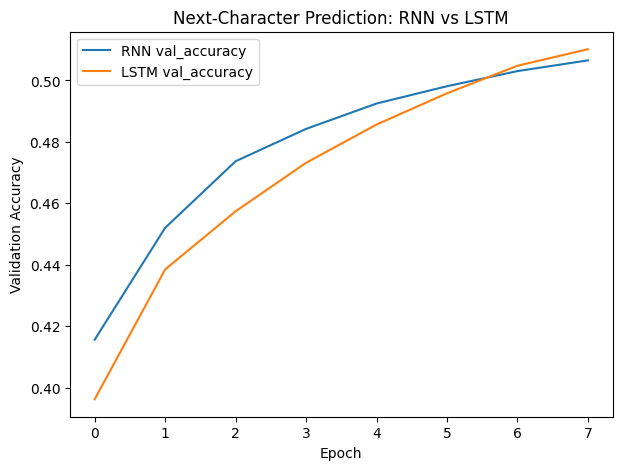

Final RNN  val_acc:  0.5065
Final LSTM val_acc: 0.5102


In [12]:
plt.figure(figsize=(7,5))
plt.plot(history_rnn.history['val_accuracy'],  label='RNN val_accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM val_accuracy')
plt.xlabel('Epoch'); plt.ylabel('Validation Accuracy')
plt.title('Next-Character Prediction: RNN vs LSTM')
plt.legend(); plt.show()

print(f"Final RNN  val_acc:  {history_rnn.history['val_accuracy'][-1]:.4f}")
print(f"Final LSTM val_acc: {history_lstm.history['val_accuracy'][-1]:.4f}")

# Summary: 

- In this task, we trained two models  a Simple RNN and an LSTM on a character-level prediction task using a corpus of children’s stories. The goal was to predict the next character in a sequence, allowing us to observe how recurrent networks handle sequential data.

#### Inresult for that:

- RNNs capture short sequential patterns but have limitations with long-term dependencies.

- LSTMs with their gating mechanisms can retain information across longer time spans, making them more suitable for text and sequential data tasks.